# Notebook 1: Intuition for ML

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader

from utils import get_mnist_dataset

In [27]:
train_dataset, test_dataset = get_mnist_dataset()

Mean: 0.13066047430038452, Std: 0.30810779333114624


In [32]:
# Let's try linear regression
# Prepare data for normal equations (X^T X)^-1 X^T y
def prepare_data_for_normal_equations(dataset):
    """Convert dataset to matrices for normal equation solution"""
    X, y = [], []
    for image, label in dataset:
        # Flatten image and add bias term (intercept)
        flattened = image.view(-1) # 784 features
        X.append(flattened)
        # One-hot encode labels for multi-class regression
        one_hot = torch.zeros(10)
        one_hot[label] = 1
        y.append(one_hot)
    X = torch.stack(X)  # (n_samples, 784) - 784 features
    y = torch.stack(y)  # (n_samples, 10) - one-hot encoded labels
    return X, y


# Solve using normal equations: theta = (X^T X)^-1 X^T y
X_train, y_train = prepare_data_for_normal_equations(train_dataset)
X_test, y_test = prepare_data_for_normal_equations(test_dataset)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

# Compute normal equations solution (use pseudo-inverse for stability)
X_T = X_train.t()  # Transpose
XTX = torch.mm(X_T, X_train)  # X^T X
XTX_pinv = torch.linalg.pinv(XTX)  # (X^T X)^+ (pseudo-inverse)
XTy = torch.mm(X_T, y_train)  # X^T y
theta = torch.mm(XTX_pinv, XTy)  # Final solution

print(f"Learned parameters shape: {theta.shape}")  # Should be (784, 10)

# Test accuracy
y_pred = torch.mm(X_test, theta)  # Apply linear model: y = X * theta
pred_labels = torch.argmax(y_pred, dim=1)  # Get predicted class labels
true_labels = torch.argmax(y_test, dim=1)  # Get true class labels
accuracy = (pred_labels == true_labels).float().mean()
print(f"Linear regression test accuracy: {accuracy:.4f}")

Training data shape: X=torch.Size([60000, 784]), y=torch.Size([60000, 10])
Test data shape: X=torch.Size([10000, 784]), y=torch.Size([10000, 10])
Learned parameters shape: torch.Size([784, 10])
Linear regression test accuracy: 0.8596


In [ ]:
# Simple averaging classifier
class AveragingClassifier(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super().__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        # Store class averages as parameters
        self.class_averages = nn.Parameter(torch.zeros(num_classes, input_size))
        
    def fit(self, dataset):
        """Compute the average image for each class"""
        # Initialize accumulators
        class_sums = torch.zeros(self.num_classes, self.input_size)
        class_counts = torch.zeros(self.num_classes)
        
        # Accumulate images by class
        for image, label in dataset:
            flattened = image.view(-1)  # Flatten 28x28 to 784
            class_sums[label] += flattened
            class_counts[label] += 1
            
        # Compute averages
        for i in range(self.num_classes):
            if class_counts[i] > 0:
                self.class_averages.data[i] = class_sums[i] / class_counts[i]
    
    def forward(self, x, sim_type: str = 'cosine'):
        # Flatten input images
        x_flat = x.view(x.size(0), -1)  # (batch_size, 784)
        # Compute dot product with each class average
        # x_flat: (batch_size, 784), class_averages: (10, 784)
        if sim_type == 'cosine':
            # Normalize vectors
            x_flat = F.normalize(x_flat, p=2, dim=1)
            class_averages = F.normalize(self.class_averages, p=2, dim=1)
            logits = torch.mm(x_flat, class_averages.t())  # (batch_size, 10)
        elif sim_type == 'euc':
            logits = -torch.cdist(x_flat, self.class_averages)  # (batch_size, 10)
        elif sim_type == 'dot':
            logits = torch.mm(x_flat, self.class_averages.t())  # (batch_size, 10)
        else:
            raise ValueError(f"Invalid similarity type: {sim_type}")
        return logits

In [30]:
# Create and train the averaging classifier
model = AveragingClassifier()
print("Fitting averaging classifier...")
model.fit(train_dataset)
print("Done!")

Fitting averaging classifier...
Done!


In [ ]:
a = theta # (784, 10)
b = model.class_averages # (10, 784)

c = b @ a
print(c.shape)

torch.Size([10, 10])


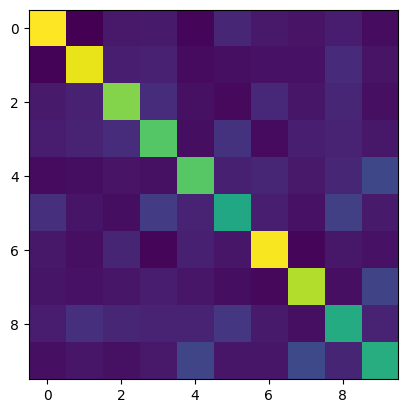

In [25]:
plt.imshow(c.softmax(dim=-1).detach().numpy())
plt.show()

In [ ]:
# See test accuracy
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
model.eval()
with torch.no_grad():
    total, correct = 0, 0
    for images, labels in test_loader:
        outputs = model(images, sim_type='cosine')
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test accuracy: {100 * correct / total}%")

Test accuracy: 82.4%
